# Example code for using session.Session

**Note:** This notebook covers several relevant methods of the `Session` and `Stim` objects, detailing some of their arguments, as well. For more details, take a look at the docstring associated with a method of interest.

**Import notes:** 

* These packages should be present if installing the conda environment from `aibs3.yml` (where **3** refers to `Python 3`). 
* `util` is a [Github repo](https://github.com/colleenjg/util/tree/aibs_mult) of mine, and the correct branch `aibs_mult` is automatically installed from `aibs3.yml`. Errors internal to the codebase involving `util` code and occurring *after* new changes have been pulled from the `AIBS_Analysis` repo *may* be due to an update of the `aibs_mult` branch of `util`. Though I will try to avoid this, consider updating the utility under those circumstances.

In [1]:
import sys

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

sys.path.extend(['.', '../'])
from analysis import session
from sess_util import sess_gen_util, sess_plot_util
from util import gen_util, plot_util

## Set paths to main data directory and the mouse dataframe

In [2]:
datadir = '../../data/AIBS'
mouse_df = '../mouse_df.csv'

If you wish to use the same formatting style as I do:

In [3]:
plot_util.linclab_plt_defaults()

## 1. Basics of initializing a Session object

After creating the session, you must run `self.extract_sess_attribs()` and `self.extract_info()`. 
This wasn't amalgamated into the `__init__` to reduce the amount of information needed to just create a session object.

### Loading ROI/running/pupil info
You can load this information when you call `self.extract_info()` or manually later by calling `self.load_roi_info()`, `self.load_run_data()` and `self.load_pup_data()`. 

In [4]:
sess = session.Session(datadir, 764704289)                       
sess.extract_sess_attribs(mouse_df=mouse_df)        
sess.extract_info(fulldict=False, roi=True, run=True, pupil=True) 


Loading stimulus dictionary...
Loading alignment dataframe...
    NOTE: Stimulus alignment pickle already exists in ../../data/AIBS/prod/mouse_413663/ophys_session_764704289
Loading sync h5 info...
Creating stimulus objects...
Loading ROI trace info...
Loading running info...
Loading pupil info...
Loading pupil tracking information.


In [5]:
sess.stim_df

,stimType,stimPar1,stimPar2,surp,stimSeg,gabfr,start2pfr,end2pfr,num2pfr,display_sequence_n,block_n
0,-1,-1,-1,-1,-1,-1,143,143,0,NaN,NaN
1,g,135,16,0,0,0,1046,1055,9,0.0,0.0
2,g,135,16,0,1,1,1055,1064,9,0.0,0.0
3,g,135,16,0,2,2,1064,1073,9,0.0,0.0
4,g,135,16,0,3,3,1073,1082,9,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
7476,b,128,right,0,2035,-1,125522,125552,30,1.0,1.0
7477,b,128,right,0,2036,-1,125552,125582,30,1.0,1.0
7478,b,128,right,1,2037,-1,125582,125612,30,1.0,1.0
7479,b,128,right,1,2038,-1,125612,125642,30,1.0,1.0


### Some information contained in the session object

Note: `Stim` objects (subclasses: `Gabors`, `Bricks`, `Grayscr`) are a separate class from `Session` objects. However, each can 
by accessed from the other using:
- from `Session objects`: `self.stims`, `self.gabors`, `self.bricks`
- from `Stim objects`: `self.sess`

In [6]:
print(f'number of rois: {sess.nrois}')
print(f'mouse number: {sess.mouse_n}')
print(f'mouse ID: {sess.mouseid}')
print(f'gabor object: {sess.gabors}')
print(f'gabor orientation standard deviation(s): {sess.gabors.ori_std}')
print(f'2p frames per sec: {sess.twop_fps:.2f}')
print(f'pupil frames per sec: {sess.pup_fps:.2f}')
print(f'stimulus frames per sec: {sess.stim_fps:.2f}')

number of rois: 644
mouse number: 6
mouse ID: 413663
gabor object: Gabors (stimulus 0 of session 764704289)
gabor orientation standard deviation(s): 0.25
2p frames per sec: 30.08
pupil frames per sec: 30.00
stimulus frames per sec: 60.00


## 2. Identifying segments of interest

From a `Session`'s `Stim`, you can get a list of segments that fit a specific criterion, e.g. **E segments** (surprise, 3rd segment).

In [7]:
gab_seg_ns = sess.gabors.get_segs_by_criteria(gabk=16, gabfr=3, surp=1, by='seg')

Then, you can access the frame numbers. 

**Note:** Specifying `ch_fl` (check flanks) ensures that only frame numbers whose flanks are within the recording are returned. In other words, any frame number too close to the start of end of the recording (based on `pre`/`post` values), will be dropped.


In [8]:
pre = 1.0
post = 1.0
twop_fr_ns = sess.gabors.get_twop_fr_by_seg(gab_seg_ns, first=True, ch_fl=[pre, post])['first_twop_fr']
stim_fr_ns = sess.gabors.get_stim_fr_by_seg(gab_seg_ns, first=True, ch_fl=[pre, post])['first_stim_fr']
pup_fr_ns = sess.get_pup_fr_by_twop_fr(twop_fr_ns.tolist(), ch_fl=[pre, post])

You can now get the **ROI/running/pupil data** corresponding these reference frames and specified `pre`/`post` periods (in sec). 

In [9]:
roi_data_df = sess.gabors.get_roi_data(twop_fr_ns, pre, post, scale=True)
run_data_df = sess.gabors.get_run_data(stim_fr_ns, pre, post, scale=True)
pup_data_df = sess.gabors.get_pup_diam_data(pup_fr_ns, pre, post, scale=True)

You can also directly obtain statistics on the data of interest

In [10]:
roi_stats_df = sess.gabors.get_roi_stats_df(
    twop_fr_ns, pre, post, integ=True, stats='mean', error='sem', byroi=False)

In [11]:
roi_stats_df

datatype               roi_traces
nan_rois_removed              yes
scaled                         no
baseline                       no
integrated                    yes
smoothing                      no
fluorescence                  dff
general ROIs sequences           
stats   None stat_mean   0.026738
             error_SEM   0.000932

Data and statistics are returned in a hierarchical dataframe with **columns** and **indices**.

This has the advantage of allowing metadata to be stored in dummy columns, however extracting data from these dataframes can be tricky, syntaxically.

In [12]:
roi_data_df

datatype                   roi_traces
nan_rois_removed                  yes
scaled                            yes
baseline                           no
integrated                         no
smoothing                          no
fluorescence                      dff
ROIs sequences time_values           
0    0         -1.000000    -0.009556
               -0.966102    -0.644810
               -0.932203    -0.214521
               -0.898305    -0.116127
               -0.864407    -0.318214
...                               ...
643  95         0.864407     0.050568
                0.898305     0.445153
                0.932203     0.108850
                0.966102     0.116475
                1.000000     0.213779

[3634560 rows x 1 columns]

To **extract a numpy array** with the correct dimensions from a hierarchical dataframe, you can use the following utility.

Here, each index level, then column level becomes an axis, **i.e. ROIs x sequences x time_values** (In this case, `squeeze_cols` is set to True to prevent each dummy column from becoming an axis.)

In [13]:
roi_data = gen_util.reshape_df_data(roi_data_df, squeeze_cols=True)
print('ROI data shape: {} ROIs x {} sequences x {} time values'.format(*roi_data.shape))

ROI data shape: 631 ROIs x 96 sequences x 60 time values


You can also retrieve the time stamps for each frame.

In [14]:
xran = roi_data_df.index.unique('time_values')

Finally, we can plot each ROIs mean activity across sequences, as well as a mean across ROIs.

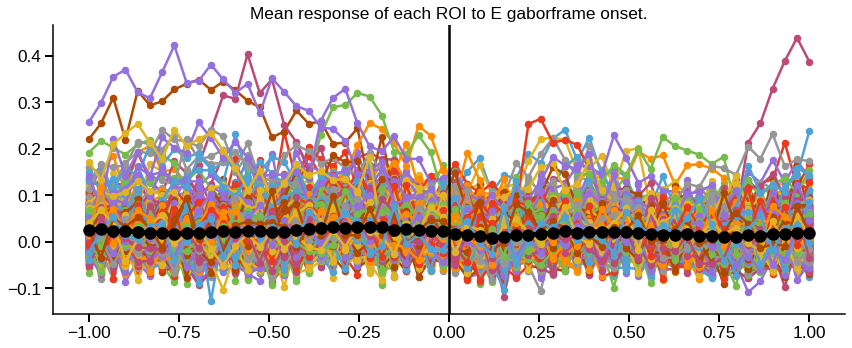

In [15]:
fig, ax = plt.subplots(1, figsize=(12, 5))
_ = ax.plot(xran, np.mean(roi_data, axis=1).T, marker='.') # mean per ROI
_ = ax.plot(xran, np.mean(np.mean(roi_data, axis=1).T, axis=1), 
            lw=5, c='k', marker='o') # mean across ROIs
_ = ax.axvline(0, c='k')
_ = ax.set_title('Mean response of each ROI to E gaborframe onset.')

### The same steps apply for Bricks

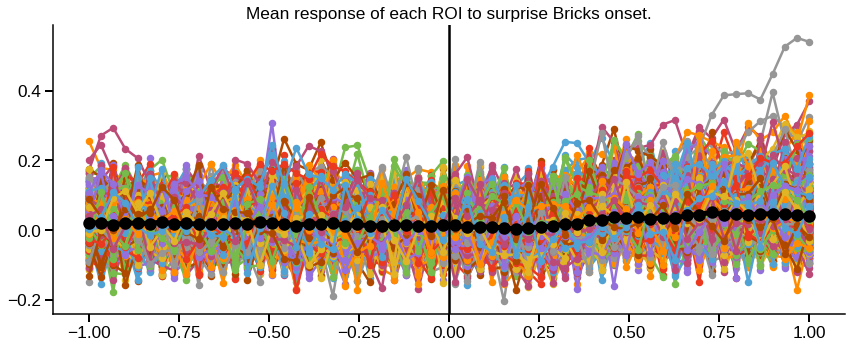

In [16]:
bri_seg_ns = sess.bricks.get_segs_by_criteria(bri_size=128, surp=1, remconsec=True, by='seg')

pre = 1.0
post = 1.0
twop_fr_ns = sess.bricks.get_twop_fr_by_seg(bri_seg_ns, first=True, ch_fl=[pre, post])['first_twop_fr']
stim_fr_ns = sess.bricks.get_stim_fr_by_seg(bri_seg_ns, first=True, ch_fl=[pre, post])['first_stim_fr']

roi_data_df = sess.bricks.get_roi_data(twop_fr_ns, pre, post, scale=True)
roi_data = gen_util.reshape_df_data(roi_data_df, squeeze_cols=True)
xran = roi_data_df.index.unique('time_values')

fig, ax = plt.subplots(1, figsize=(12, 5))
_ = ax.plot(xran, np.mean(roi_data, axis=1).T, marker='.') # mean per ROI
_ = ax.plot(xran, np.mean(np.mean(roi_data, axis=1).T, axis=1), 
            lw=5, c='k', marker='o') # mean across ROIs
_ = ax.axvline(0, c='k')
_ = ax.set_title('Mean response of each ROI to surprise Bricks onset.')

## 3. Additional tips on indexing a hierarchical dataframe

In [17]:
# getting columns
roi_data_series = roi_data_df['roi_traces']

# getting specific ROIs (0, 3, 4)
roi_data_specific_rois = roi_data_df.loc[([0, 3, 4])]

# getting specific sequences (0, 3, 4 - any ROI) <- second order index, so requires a pandas slice
roi_data_specific_seqs = roi_data_df.loc[(pd.IndexSlice[:, [0, 3, 4]]), ]

# using both index and columns
roi_data_specific = roi_data_df.loc[(pd.IndexSlice[:, [0, 3, 4]]), ('roi_traces', 'yes')]
roi_data_specific

scaled                           yes
baseline                          no
integrated                        no
smoothing                         no
fluorescence                     dff
ROIs sequences time_values          
0    0         -1.000000    0.045433
               -0.966102   -0.303140
               -0.932203   -0.301464
               -0.898305   -0.219794
               -0.864407    0.065587
...                              ...
643  4          0.864407   -0.513739
                0.898305   -0.143983
                0.932203    0.000693
                0.966102    0.140502
                1.000000    0.283351

[113580 rows x 1 columns]

### 4. Retrieving several Session objects, based on criteria

This function keeps track of which Sessions or Mice must be left out (e.g., due to a problem with the session data or the mouse didn't see the stimulus of interest <- the latter only comes up with pilot data).

In [18]:
omit_sess, omit_mice = sess_gen_util.all_omit(runtype='prod')

You can now retrieve the mouse number, session number and ID that fit specific the criteria, 

e.g., **session number 1, 2 or 3**, **production**, **dendritic plane**

In [19]:
mouse_ns, sess_ns, sessids = sess_gen_util.get_sess_vals(
    mouse_df, ['mouse_n', 'sess_n', 'sessid'], sess_n=[1, 2, 3], runtype='prod', plane='dend', omit_sess=omit_sess, 
    omit_mice=omit_mice)

In [20]:
print('\n'.join([f'mouse {m}: {sid} (session {n})' for m, sid, n in zip(mouse_ns, sessids, sess_ns)]))


mouse 6: 764704289 (session 1)
mouse 6: 765193831 (session 2)
mouse 6: 766502238 (session 3)
mouse 7: 777914830 (session 1)
mouse 7: 778864809 (session 2)
mouse 7: 779650018 (session 3)
mouse 9: 826187862 (session 1)
mouse 9: 826773996 (session 2)
mouse 9: 827833392 (session 3)
mouse 10: 826338612 (session 1)
mouse 10: 826819032 (session 2)
mouse 10: 828816509 (session 3)
mouse 11: 823453391 (session 1)
mouse 11: 824434038 (session 2)
mouse 11: 825180479 (session 3)


You can now **initialize the Sessions** using this function which does the additional extraction steps automatically.

In [21]:
dend_sessions = sess_gen_util.init_sessions(sessids[:5], datadir, mouse_df, fulldict=False, omit=True, runtype='prod', 
    roi=True, run=True)

soma_sessions = sess_gen_util.init_sessions([758519303], datadir, mouse_df, fulldict=False, omit=True, runtype='prod', 
    roi=True, run=True)


Creating session 764704289...

Loading stimulus dictionary...
Loading alignment dataframe...
    NOTE: Stimulus alignment pickle already exists in ../../data/AIBS/prod/mouse_413663/ophys_session_764704289
Loading sync h5 info...
Creating stimulus objects...
Loading ROI trace info...
Loading running info...
Finished session 764704289.

Creating session 765193831...

Loading stimulus dictionary...
Loading alignment dataframe...
    NOTE: Stimulus alignment pickle already exists in ../../data/AIBS/prod/mouse_413663/ophys_session_765193831
Loading sync h5 info...
Creating stimulus objects...
Loading ROI trace info...
Loading running info...
Finished session 765193831.

Creating session 766502238...

Loading stimulus dictionary...
Loading alignment dataframe...
    NOTE: Stimulus alignment pickle already exists in ../../data/AIBS/prod/mouse_413663/ophys_session_766502238
Loading sync h5 info...
Creating stimulus objects...
Loading ROI trace info...
Loading running info...
Finished session 

Then run through the sessions and do whatever with them.

In [22]:
for sess in dend_sessions + soma_sessions:
    print(f'Session ID: {sess.sessid} (mouse {sess.mouse_n}, session {sess.sess_n})')
    for stimtype in ['bricks', 'gabors']:
        stim = sess.get_stim(stimtype)
        segs = stim.get_segs_by_criteria(bri_size=128, surp=1, gabk=16, gabfr=3, 
                                  by='seg', remconsec=(stimtype == 'bricks'))
        print(f'    {stimtype}: {len(segs)} sequences')

Session ID: 764704289 (mouse 6, session 1)
    bricks: 33 sequences
    gabors: 96 sequences
Session ID: 765193831 (mouse 6, session 2)
    bricks: 34 sequences
    gabors: 98 sequences
Session ID: 766502238 (mouse 6, session 3)
    bricks: 29 sequences
    gabors: 94 sequences
Session ID: 777914830 (mouse 7, session 1)
    bricks: 32 sequences
    gabors: 83 sequences
Session ID: 778864809 (mouse 7, session 2)
    bricks: 29 sequences
    gabors: 88 sequences
Session ID: 758519303 (mouse 1, session 1)
    bricks: 31 sequences
    gabors: 94 sequences


### 5. Retrieving ROI masks from session.

Boolean ROI masks can be obtained for Session.

For **dendritic sessions**, the Session is built to assume that `EXTRACT` (not `AIBS`) ROI data is to be used. This can be checked by checking `self.dend`. As long as `self.dend` is properly set, the correct masks will be loaded.


In [23]:
dend_sess = dend_sessions[0]
print(f'Dendritic session, ROI type: {dend_sess.dend}')

soma_sess = soma_sessions[0]
print(f'Somatic session, ROI type: {soma_sess.dend}')

Dendritic session, ROI type: extr
Somatic session, ROI type: aibs


Calling the attribute loads the boolean mask into the object: **ROI x height x width**

In [24]:
dend_mask = dend_sess.roi_masks
soma_mask = soma_sess.roi_masks

One way to check which ROIs are not valid, is using `self.get_nanrois()`

In [25]:
dend_nan_masks = np.asarray(dend_sess.get_nanrois(fluor='dff'))
soma_nan_masks = np.asarray(soma_sess.get_nanrois(fluor='dff'))

dend_valid = np.ones(len(dend_mask))
dend_valid[dend_nan_masks] = 0

soma_valid = np.ones(len(soma_mask))
soma_valid[soma_nan_masks] = 0

This is a tool to visualize ROIs, where specific ROIs can be set to red using a `valid_mask`.

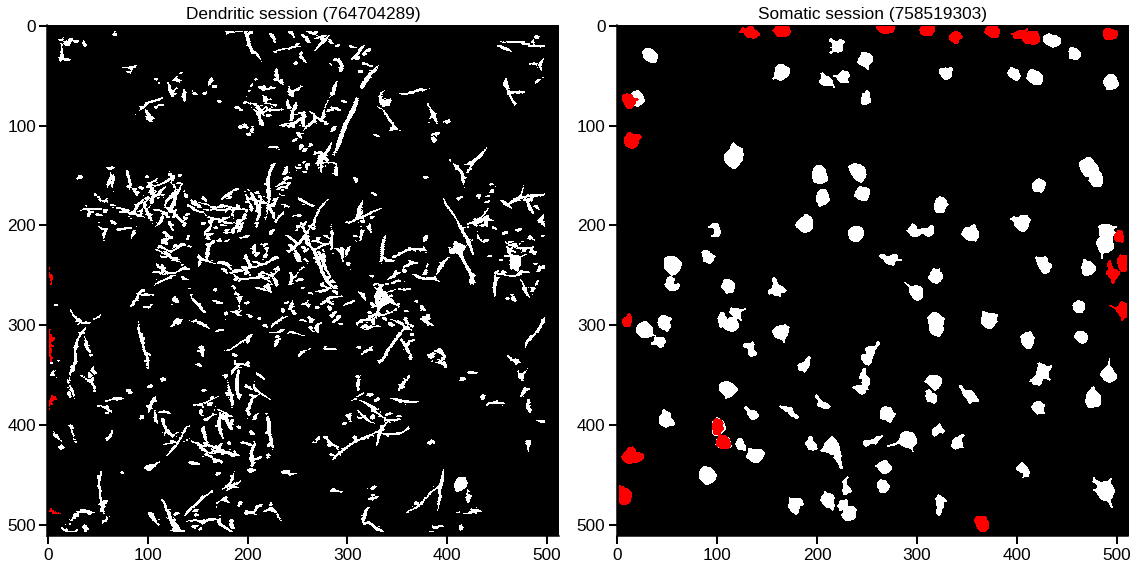

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(16, 9))
sess_plot_util.plot_ROIs(ax[0], dend_mask, valid_mask=dend_valid)
_ = ax[0].set_title(f'Dendritic session ({dend_sess.sessid})')

sess_plot_util.plot_ROIs(ax[1], soma_mask, valid_mask=soma_valid)
_ = ax[1].set_title(f'Somatic session ({soma_sess.sessid})')

This is a tool to visualize ROI contours, optionally localized around an ROI of interest.

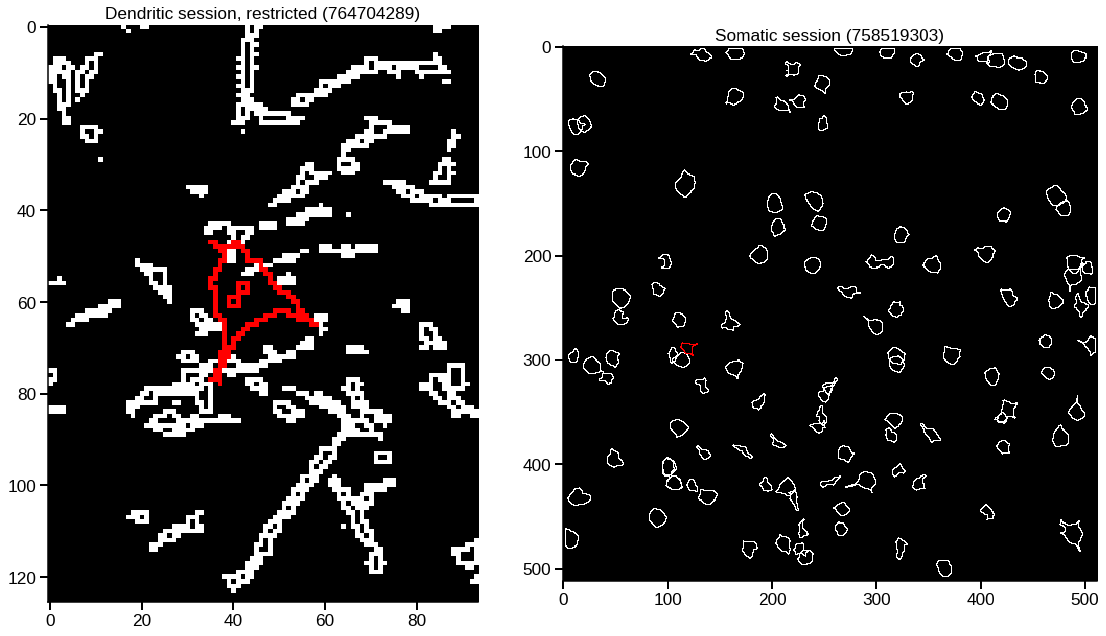

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(16, 9))
sess_plot_util.plot_ROI_contours(ax[0], dend_mask, outlier=527, restrict=True)
_ = ax[0].set_title(f'Dendritic session, restricted ({dend_sess.sessid})')

sess_plot_util.plot_ROI_contours(ax[1], soma_mask, outlier=3)
_ = ax[1].set_title(f'Somatic session ({soma_sess.sessid})')

### 6. Last notes

List of the methods/attributes attached to `Session` and `Stim` objects.

In [28]:
print('Session: {}'.format(', '.join(list(filter(lambda x: ('__' not in x), dir(sess))))))

Session: _dend, _get_roi_facts, _init_directory, _init_roi_facts_df, _load_align_df, _load_stim_dict, _load_stims, _load_sync_h5_data, _roi_masks, _set_dend_type, _set_nanrois, _set_roi_attributes, align_pkl, all_files, any_files, behav_video_h5, bricks, check_flanks, correct_data_h5, date, dend, depth, dir, drop_stim_fr, droptol, expdir, expid, extract_info, extract_sess_attribs, gabors, get_active_rois, get_nanrois, get_nrois, get_plateau_roi_traces, get_pup_data, get_pup_fr_by_twop_fr, get_roi_seqs, get_roi_traces, get_run_velocity, get_run_velocity_by_fr, get_stim, get_twop_fr_ran, grayscr, home, line, load_pup_data, load_roi_info, load_run_data, mouse_dir, mouse_n, mouseid, n_drop_stim_fr, n_stims, nanrois_dff, notes, nrois, pass_fail, plane, post_blank, pre_blank, procdir, pup_data_h5, pup_fps, pup_fr_interv, pup_video_h5, roi_extract_json, roi_facts_df, roi_mask_file, roi_masks, roi_names, roi_objectlist, roi_trace_dff_h5, roi_trace_h5, run_data, runtype, segid, sess_gen, sess_n

In [29]:
print('Gabors: {}'.format(', '.join(list(filter(lambda x: ('__' not in x), dir(sess.gabors))))))

Gabors: _add_stim_fr_info, _add_twop_fr_info, _check_brick_prod_params, _set_block_params, _update_block_params, act_n_blocks, blank_per, block_params, deg_per_pix, disp_seq, exp_block_len_s, exp_n_blocks, extra_segs, get_A_frame_1s, get_A_segs, get_all_surp_segs, get_all_surp_stim_fr, get_first_surp_segs, get_first_surp_stim_fr_trans, get_n_twop_fr_by_seg, get_pup_diam_data, get_pup_diam_stats_df, get_roi_data, get_roi_stats_df, get_run, get_run_data, get_run_stats_df, get_segs_by_criteria, get_segs_by_twopfr, get_stats_df, get_stim_beh_sub_df, get_stim_df_by_criteria, get_stim_fr_by_criteria, get_stim_fr_by_seg, get_stim_par_by_seg, get_stim_par_by_twopfr, get_twop_fr_by_seg, n_patches, n_seg_per_set, ori_kaps, ori_ran, ori_std, oris, oris_pr, phase, pos_x, pos_x_ran, pos_y, pos_y_ran, post, pre, reg_max_s, reg_min_s, seg_len_s, seg_ps_nobl, seg_ps_wibl, sess, set_len_s, sf, size_ran, sizes_pr, stim_fps, stim_n, stim_seg_list, stimtype, surp_max_s, surp_min_s, units, win_size


In [30]:
print('Bricks: {}'.format(', '.join(list(filter(lambda x: ('__' not in x), dir(sess.bricks))))))

Bricks: _add_stim_fr_info, _add_twop_fr_info, _check_brick_prod_params, _set_block_params, _update_block_params, act_n_blocks, blank_per, block_params, deg_per_pix, direcs, disp_seq, exp_block_len_s, exp_n_blocks, extra_segs, flipfrac, get_all_surp_segs, get_all_surp_stim_fr, get_dir_segs_reg, get_first_surp_segs, get_first_surp_stim_fr_trans, get_n_twop_fr_by_seg, get_pup_diam_data, get_pup_diam_stats_df, get_roi_data, get_roi_stats_df, get_run, get_run_data, get_run_stats_df, get_segs_by_criteria, get_segs_by_twopfr, get_stats_df, get_stim_beh_sub_df, get_stim_df_by_criteria, get_stim_fr_by_criteria, get_stim_fr_by_seg, get_twop_fr_by_seg, n_bricks, reg_max_s, reg_min_s, seg_len_s, seg_ps_nobl, seg_ps_wibl, sess, sizes, speed, stim_fps, stim_n, stim_n_all, stim_seg_list, stimtype, surp_max_s, surp_min_s, units
